### In this notebook, we test our results on a CANDELS data.
    This is an experiment example demonstated with CANDELS.
    Our goal is to train the NN learn the pattern from [multiband-photometry] -> [redshfit z]

In [149]:
from astropy.table import Table, hstack, vstack, join #astropy is used
from astropy.io import fits
import numpy as np
from scipy.stats import pearsonr

import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from astropy.io import ascii

In [ ]:
warnings.filterwarnings('ignore') #there is a unit warning we choose to ignore
import urllib.request

#read data from url
url = 'https://archive.stsci.edu/hlsps/candels/cosmos/catalogs/v2/hlsp_candels_hst_wfc3_cosmos_multi_v2_redshift-cat.txt'
data_Y = ascii.read(url)

data_X = Table.read('https://archive.stsci.edu/hlsps/candels/cosmos/catalogs/v1/hlsp_candels_hst_wfc3_cos-tot-multiband_f160w_v1-1photom_cat.fits')

data = join(data_X, data_Y, keys = 'ID' ).to_pandas() #following readme.txt

In [156]:
#grab all flux items
flux_names = [i for i in list(data_X.columns) if 'FLUX' in i]
flux_err_names = [i for i in flux_names if 'ERR' in i]
flux_names = [i for i in flux_names if 'ERR' not in i]

In [157]:
# This is an experiment test, thus, we require clean data

#add a requirement on S/N, at list 30 bands have S/N >5, with WFC3_F160W_FLUX have  S/N >5
#S/N requirement
sn = np.array(data[flux_names])/np.array(data[flux_err_names])
row_sums = sn.sum(axis=1)
sn_cut_1 = (data['WFC3_F160W_FLUX']/data['WFC3_F160W_FLUXERR']>=5)&(row_sums>30)


#The positive cut basically says we don't want -99 in data if it is not detected
#There should be a better way to handle nan-detections in real projects
sn_cut = (data[flux_names]> 0).all(axis=1)&sn_cut_1 #positive cut


print(f'From the sn cut, we go from {len(data)} to {len(data[sn_cut_1])} sources')
print(f'From the positive cut, we go from {len(data[sn_cut_1])} to {len(data[sn_cut])} sources')

#follow the 8-1-1 rule to do the seperation
train_size = int(0.8*len(data[sn_cut]))
val_size= int(0.1*len(data[sn_cut]))

From the sn cut, we go from 38671 to 32408 sources
From the positive cut, we go from 32408 to 5246 sources


In [159]:
#There are multiple z_estimates avalable
y_use = 'z_best'

input_data_x = np.array(data[flux_names][sn_cut][:train_size]) #photometry, all 40 bands
input_data_y = np.array(data[y_use][sn_cut][:train_size]).astype('float64') #redshift

input_data_x_val = np.array(data[flux_names][sn_cut][train_size:train_size+val_size]) #photometry, all 40 bands
input_data_y_val = np.array(data[y_use][sn_cut][train_size:train_size+val_size]).astype('float64') #redshift

In [160]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
#examine the input data first
import sys
sys.path.append('../src')

from evaluate_input_data import test_correlation, show_stats

#calcualte the pearson scores >0.5 is considered correlated
test_correlation(input_data_x, input_data_y)

#show mean, min, max, std
show_stats(input_data_x, input_data_y)




Feature 0: correlation = -0.0943, p-value = 9.4472e-10
Feature 1: correlation = -0.0852, p-value = 3.2668e-08
Feature 2: correlation = -0.1069, p-value = 3.8893e-12
Feature 3: correlation = -0.1371, p-value = 4.7069e-19
Feature 4: correlation = -0.1161, p-value = 4.6643e-14
Feature 5: correlation = -0.1372, p-value = 4.4770e-19
Feature 6: correlation = -0.1745, p-value = 4.7219e-30
Feature 7: correlation = -0.1675, p-value = 8.5931e-28
Feature 8: correlation = -0.2173, p-value = 4.9169e-46
Feature 9: correlation = -0.2067, p-value = 9.9036e-42
Feature 10: correlation = -0.2257, p-value = 1.2910e-49
Feature 11: correlation = -0.0930, p-value = 1.5780e-09
Feature 12: correlation = -0.1137, p-value = 1.5076e-13
Feature 13: correlation = -0.1179, p-value = 1.8689e-14
Feature 14: correlation = -0.1162, p-value = 4.3645e-14
Feature 15: correlation = -0.1084, p-value = 1.9190e-12
Feature 16: correlation = -0.1191, p-value = 9.9996e-15
Feature 17: correlation = -0.1169, p-value = 2.9788e-14
F

In [163]:
#Normalization
from norm_input import return_scaler, transform_val_or_test

#do not train scaler for each sample, use one x, one y scale for all sames 

#For this project, we know two things matter: 
#   1. the magnitude of galaxy (how bright it is associated with how far it is -> with z)
#   2. the shape of the SED 

#Hence, we could not do a standard scaler normalization which normalize each feature independently and we lose shape information from it
#instead, we do a row-normalization (keep the shape) while we keep luminosity (e.g., WFC3_160 photometry in this case), as an extra feature.

brightness = input_data_x[:, 14].reshape(-1, 1)#brightness in F160w band
brightness_scaled, scaler_L = return_scaler(brightness) #scale this using a standardscaler


sed_shape = input_data_x #- brightness 
sed_shape = sed_shape / np.linalg.norm(sed_shape, axis=1, keepdims=True) #horizontal norm, keep the shape of the source

x_training_scaled = np.column_stack([
    brightness_scaled,  # 1 feature: overall brightness
    sed_shape    # 42 features: SED shape (normalized)
])

y_training_scaled, scaler_y = return_scaler(input_data_y)

x_train_tensor = torch.tensor(x_training_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_training_scaled, dtype=torch.float32).reshape(-1, 1) #y is 1D: (n,) shape




#do not fit a different scaler for validation or test, same approach as the training scaler

brightness_val = input_data_x_val[:, 14].reshape(-1, 1)

brightness_val_scaled = transform_val_or_test(brightness_val ,scaler_L)

sed_shape_val = input_data_x_val #- brightness_val
sed_shape_val = sed_shape_val / np.linalg.norm(sed_shape_val, axis=1, keepdims=True)

x_val_scaled = np.column_stack([
    brightness_val_scaled ,  # 1 feature: overall brightness
    sed_shape_val    # 42 features: SED shape (normalized)
])

x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(transform_val_or_test(input_data_y_val, scaler_y), dtype=torch.float32).reshape(-1, 1)


In [164]:
#create model

from model import create_model,WeightedMSELoss, train_model

#You could design the model yourself, here we create two models for the class project

def ANNz_original():

  # Create and train model
  model = create_model(
      input_dim=x_train_tensor.shape[1],  # 5
      hidden_size=10,
      output_dim=1,
      depth=2,
      activation='Sigmoid',

  )

  print(f"\nModel architecture:\n{model}")

  # Train
  losses, val_losses = train_model(
      model,
      x_train_tensor,
      y_train_tensor,
      epochs=1000, #following the paper
      lr=0.01,
      reg_type='l2',
      lambda_reg=0.0001,
      x_val = x_val_tensor,
      y_val = y_val_tensor
  )

  return model, losses, val_losses


def update_SDSS():

  # Create and train model
  model = create_model(
      input_dim=x_train_tensor.shape[1],  # 5
      hidden_size=64,
      output_dim=1,
      depth=4,
      activation='ReLU',

   )

  print(f"\nModel architecture:\n{model}")

  # Train
  losses, val_losses = train_model(
      model,
      x_train_tensor,
      y_train_tensor,
      epochs=6000, #following the paper
      lr=0.001,
      reg_type='l2',
      lambda_reg=0.001,
      x_val = x_val_tensor,
      y_val = y_val_tensor
  )

  return model, losses, val_losses


#model_ANNz, losses_ANNz, val_losses_ANNz = ANNz_original()
model_update_SDSS, losses_update_SDSS, val_losses_update_SDSS = update_SDSS()



Model architecture:
Sequential(
  (0): Linear(in_features=44, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=1, bias=True)
)


Training:  65%|██████▍   | 3876/6000 [00:08<00:04, 455.50it/s, Train=0.063994, Val=0.345706, Best=0.300355, Patience=994/1000]


Early stopping at epoch 3876


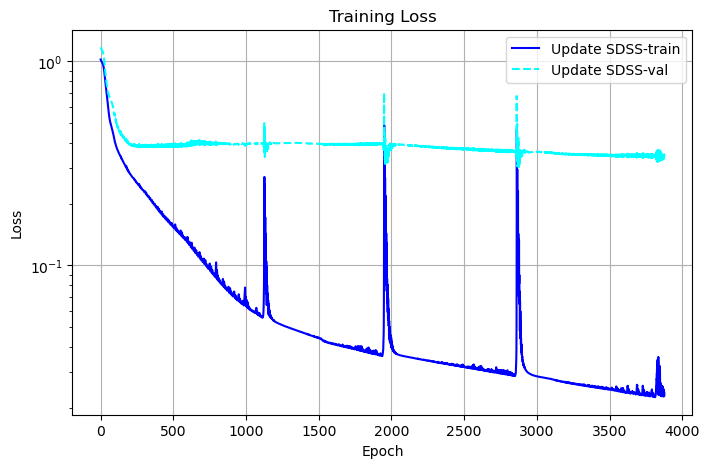

Final loss: 0.023062


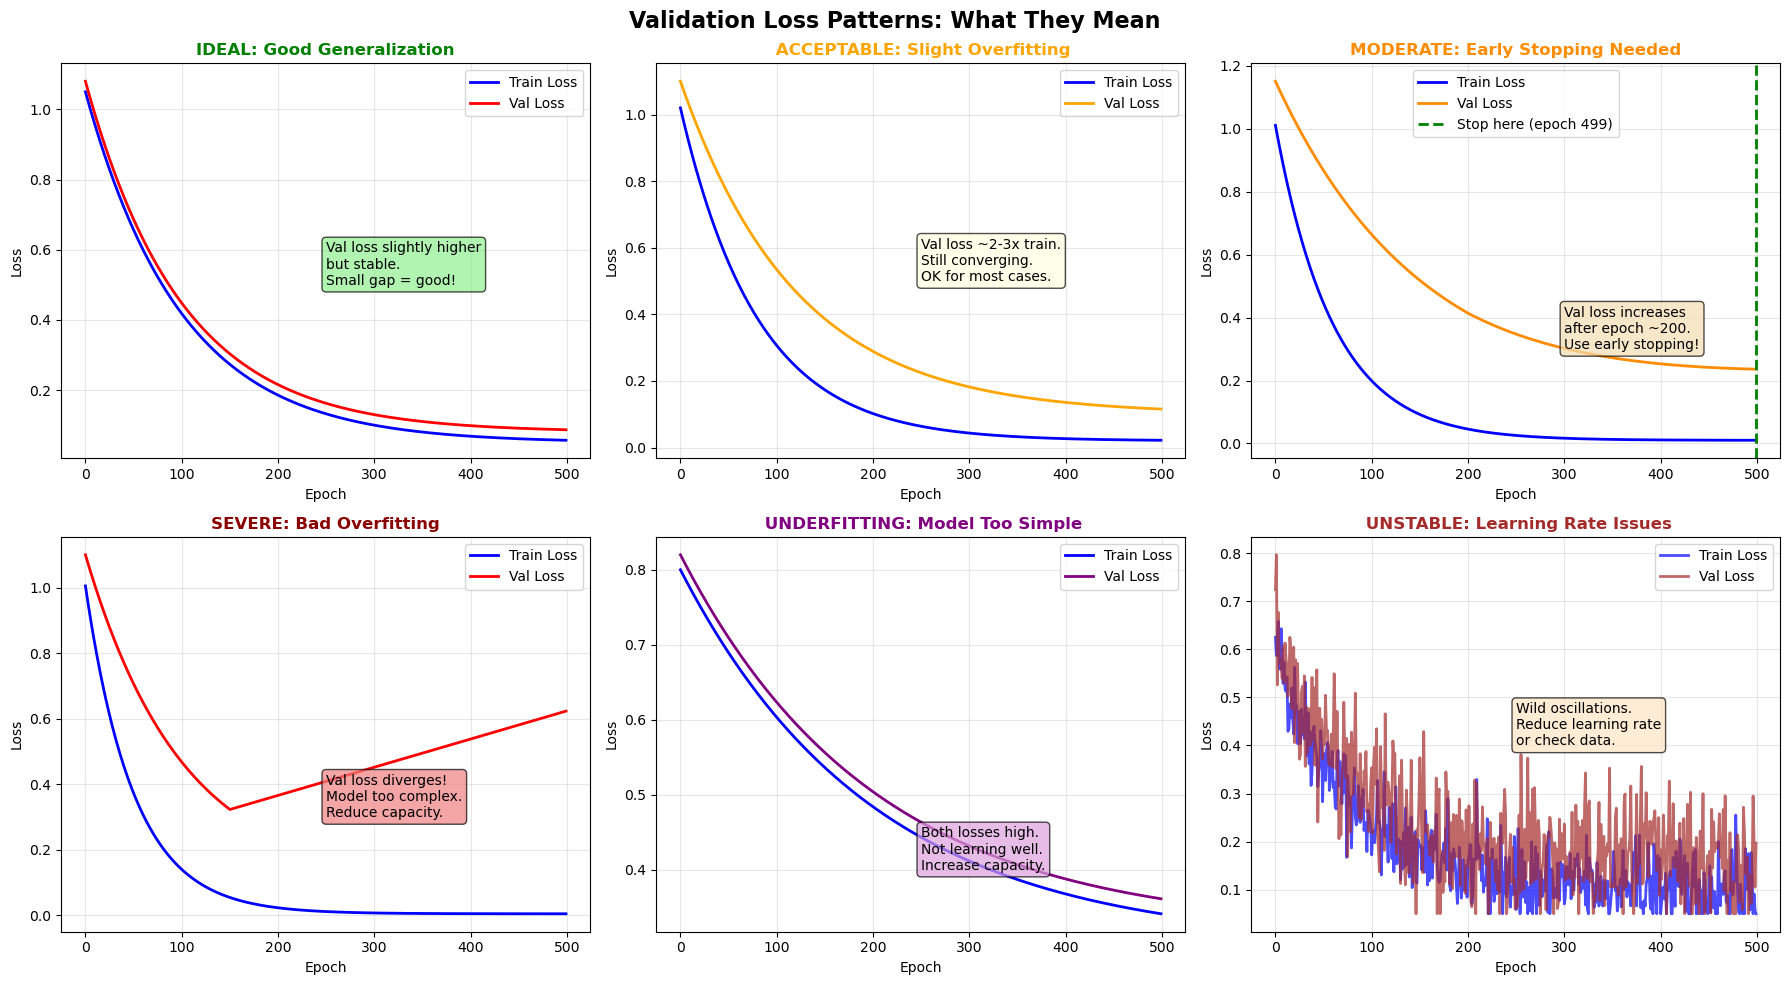

VALIDATION LOSS PATTERNS - QUICK REFERENCE

✅ IDEAL:
   - Val loss slightly > train loss (1.2-1.5x)
   - Both decrease smoothly
   - Val loss plateaus at similar level to train
   - Small gap remains constant

⚠️ ACCEPTABLE (Slight Overfitting):
   - Val loss 2-3x train loss
   - Both still decreasing
   - Gap widens slowly
   - Solution: Train a bit longer, add slight regularization

⚠️ MODERATE (Early Stopping Needed):
   - Val loss decreases then increases
   - Train loss continues to decrease
   - Clear divergence point visible
   - Solution: Use early stopping at minimum val loss

❌ SEVERE (Bad Overfitting):
   - Val loss >> train loss (5-30x or more)
   - Val loss increases significantly over time
   - Train loss very low
   - Solution: Reduce model size, add dropout, stronger regularization

❌ UNDERFITTING:
   - Both losses high and similar
   - Little to no gap
   - Both plateau at high values
   - Solution: Increase model capacity, train longer, reduce regularization

❌ UNSTAB

In [165]:
# Plot losses
plt.figure(figsize=(8, 5))
#plt.plot(range(len(losses_ANNz)), losses_ANNz, label='ANNz-train', c = 'r')
#plt.plot(range(len(val_losses_ANNz)), val_losses_ANNz, label='ANNz-val', c = 'orange', ls = '--')

plt.plot(range(len(losses_update_SDSS)),losses_update_SDSS, label='Update SDSS-train', c = 'b')
plt.plot(range(len(val_losses_update_SDSS)),val_losses_update_SDSS, label='Update SDSS-val', c = 'cyan', ls = '--')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.show()

#print(f"\nFinal loss: {losses_ANNz[-1]:.6f}")
print(f"Final loss: {losses_update_SDSS[-1]:.6f}")

#If you are not familar of reading training and validation loss, 
# here is a VALIDATION LOSS PATTERNS - QUICK REFERENCE guide you could call

import val_loss_reference_guide
val_loss_reference_guide.load_guide()

### Test and Predict

In [166]:
### work with test data

input_data_x_test = np.array(data[flux_names][sn_cut][train_size+val_size:]) #ugriz photometry, from ANNz readme
input_data_y_test = np.array(data[y_use][sn_cut][train_size+val_size:]).astype('float64') #redshift


#x_test_tensor =  torch.tensor(transform_val_or_test(input_data_x_test,scaler_x),dtype=torch.float32)

brightness_test = input_data_x_test[:, 14].reshape(-1, 1)

brightness_test_scaled = transform_val_or_test(brightness_test ,scaler_L)

sed_shape_test = input_data_x_test #- brightness_test
sed_shape_test= sed_shape_test / np.linalg.norm(sed_shape_test, axis=1, keepdims=True)

x_test_scaled = np.column_stack([
    brightness_test_scaled ,  # 1 feature: overall brightness
    sed_shape_test    # 40 features: SED shape (normalized)
])

x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)


def predict(model, x_test_tensor, input_data_y_test ):
      
      model.eval()
      with torch.no_grad():
            y_pred = model(x_test_tensor).numpy().flatten()
            y_real_value = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
            L2_error = np.sqrt(np.mean(((input_data_y_test -y_real_value.flatten())**2)))

      return y_pred, y_real_value, L2_error


Average of input y is 1.0535694866920151 
Sigma NMAD is 0.047492734447967824 


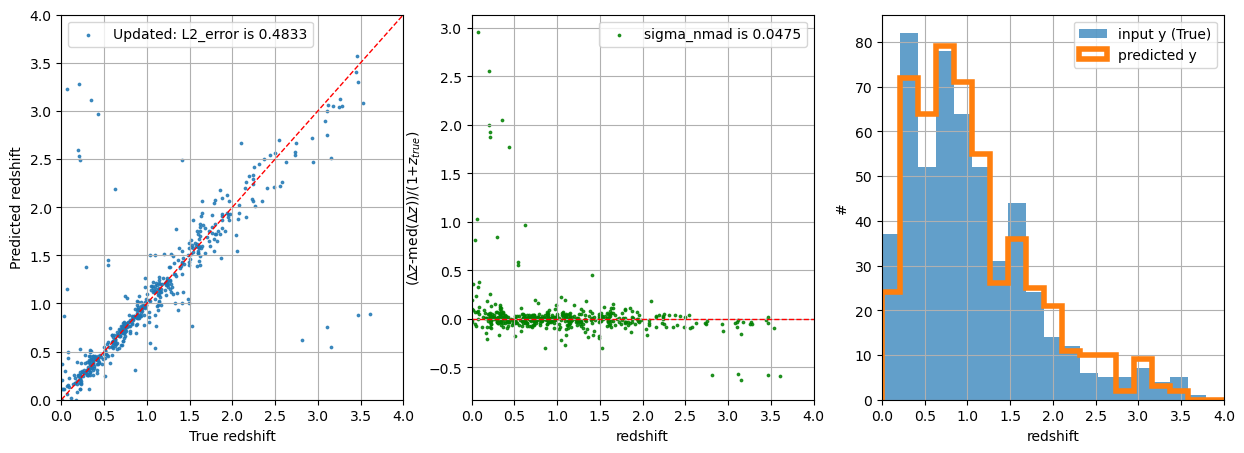

In [171]:
fig, axs = plt.subplots(1, 3, figsize = (15,5))

model  = model_update_SDSS
y_pred, y_real_value, L2_error = predict(model, x_test_tensor, input_data_y_test )
y_real_value = y_real_value.flatten()
delta_z = (y_real_value -input_data_y_test) 
sigma_nmad = 1.48 * np.median(np.abs((delta_z - np.median(delta_z))/(1 + input_data_y_test)))


# Or with outlier rejection (often used with σ_NMAD)
mask = np.abs(delta_z) < 0.15  # common 3σ cut
sigma_nmad_clean = 1.48 * np.median(np.abs(delta_z[mask] - np.median(delta_z[mask])))

ax = axs[0]
ax.scatter(input_data_y_test, y_real_value, s = 3, label = f'Updated: L2_error is {round(L2_error,4)}', alpha = 0.8)
ax.plot([0,10],[0,10], lw = 1, ls = '--', c = 'r')
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_xlabel('True redshift')
ax.set_ylabel('Predicted redshift')


ax.legend()
ax.grid()

ax = axs[1]

ax.scatter(input_data_y_test, (delta_z - np.median(delta_z))/(1 + input_data_y_test), s = 3, label = f'sigma_nmad is {round(sigma_nmad,4)}', alpha = 0.8, c = 'green')
ax.plot([0,10],[0,0], lw = 1, ls = '--', c = 'r')
ax.set_xlim(0,4)
ax.set_xlabel('redshift')
ax.set_ylabel('($\Delta z$-med($\Delta z$))/(1+$z_{true})$')


ax.legend()
ax.grid()


ax = axs[2]
ax.hist(input_data_y_test, bins = np.linspace(0,4,20), label = 'input y (True)', alpha = 0.7)
ax.hist(y_real_value, bins = np.linspace(0,4,20), label = 'predicted y', lw = 4, histtype='step')
ax.set_xlim(0,4)
ax.set_xlabel('redshift')
ax.set_ylabel('#')


ax.legend()
ax.grid()

print(f'Average of input y is {np.mean(input_data_y_test)} ')
print(f'Sigma NMAD is {np.mean(sigma_nmad )} ')

526